In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Pacific_Extent = pd.read_excel(filepath, sheet_name='Pacific-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Pacific_Extent)
fp.date_time(Pacific_Extent)

Extent       Date
0     668714.275 1979-01-01
1     566930.458 1979-02-01
2     688420.115 1979-03-01
3     859963.043 1979-04-01
4    1127120.160 1979-05-01
..           ...        ...
533  1134056.102 2023-06-01
534  1484824.377 2023-07-01
535  1671324.717 2023-08-01
536  1726376.097 2023-09-01
537  1690631.996 2023-10-01

[538 rows x 2 columns]

In [5]:
scaler = MinMaxScaler()
Pacific_Extent['Extent'] = scaler.fit_transform(Pacific_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 5
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Pacific_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((522, 12, 1), (522,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Pacific_model_LT5/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 17s 211ms/step - loss: 0.2441 - root_mean_squared_error: 0.4941 - val_loss: 0.2171 - val_root_mean_squared_error: 0.4659
Epoch 2/50
53/53 [==============================] - 10s 184ms/step - loss: 0.1421 - root_mean_squared_error: 0.3770 - val_loss: 0.0458 - val_root_mean_squared_error: 0.2140
Epoch 3/50
53/53 [==============================] - 9s 176ms/step - loss: 0.0453 - root_mean_squared_error: 0.2128 - val_loss: 0.0365 - val_root_mean_squared_error: 0.1910
Epoch 4/50
53/53 [==============================] - 9s 181ms/step - loss: 0.0423 - root_mean_squared_error: 0.2057 - val_loss: 0.0361 - val_root_mean_squared_error: 0.1900
Epoch 5/50
53/53 [==============================] - 10s 183ms/step - loss: 0.0405 - root_mean_squared_error: 0.2012 - val_loss: 0.0325 - val_root_mean_squared_error: 0.1803
Epoch 6/50
53/53 [==============================] - 9s 169ms/step - loss: 0.0398 - root_mean_squared_error: 0.1995 - val_loss: 0.0299 - v

53/53 [==============================] - 10s 192ms/step - loss: 0.0139 - root_mean_squared_error: 0.1179 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0923
Epoch 30/50
53/53 [==============================] - 2s 34ms/step - loss: 0.0137 - root_mean_squared_error: 0.1169 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0941
Epoch 31/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0150 - root_mean_squared_error: 0.1224 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0948
Epoch 32/50
53/53 [==============================] - 2s 34ms/step - loss: 0.0137 - root_mean_squared_error: 0.1171 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0940
Epoch 33/50
53/53 [==============================] - 2s 34ms/step - loss: 0.0143 - root_mean_squared_error: 0.1195 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0994
Epoch 34/50
53/53 [==============================] - 10s 196ms/step - loss: 0.0135 - root_mean_squared_error: 0.1161 - val_loss: 0.0082 - val_root_mea

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

5.21228529214859 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

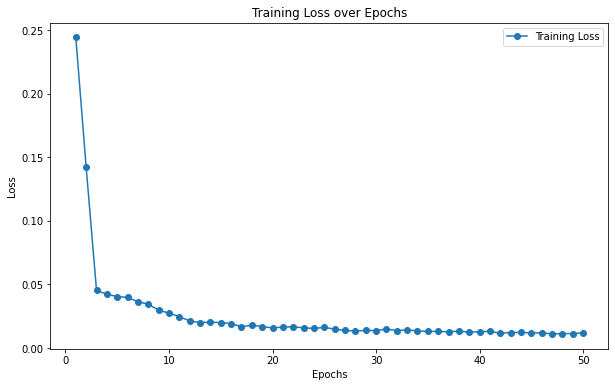

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

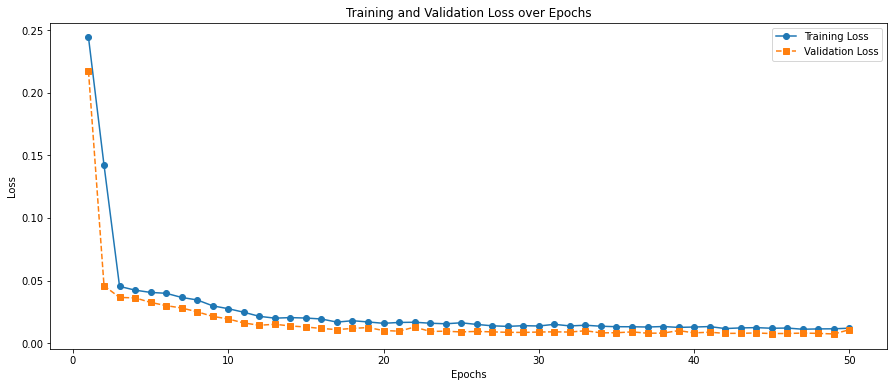

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Pacific_model_LT5/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 26ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.07893191414767033
MAE : 0.05936827179406059


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

Train Predictions  Actual Extent
0        1.631432e+06    2203401.829
1        1.466105e+06    1960480.542
2        1.196940e+06    1264318.504
3        8.903630e+05     863206.294
4        6.345234e+05     635624.004
5        4.861582e+05     460009.672
6        5.231863e+05     610848.036
7        7.678208e+05     819257.445
8        1.101533e+06    1129627.707
9        1.443661e+06    1463383.236
10       1.748811e+06    1614536.727
11       1.918918e+06    1862498.612
12       1.892068e+06    2099349.296
13       1.651605e+06    1981614.046
14       1.288169e+06    1433022.369
15       9.345443e+05     826739.716
16       6.437561e+05     477145.887
17       5.127738e+05     314469.289
18       5.883362e+05     463134.749
19       8.231176e+05     946522.292
20       1.140660e+06    1309266.570
21       1.489970e+06    1507947.309
22       1.739832e+06    1804167.937
23       1.898295e+06    1908002.139
24       1.872107e+06    1892748.521
25       1.664570e+06    1601079.640
26       1.329506e+06    1327804.521
27       9.600430e+05     812074.231
28       6.538462e+05     493355.897
29       4.834355e+05     317229.330
30       5.343870e+05     425777.624
31       8.548986e+05     827172.620
32       1.219110e+06    1162367.223
33       1.513068e+06    1413734.261
34       1.724822e+06    1574257.849
35       1.809324e+06    1786961.251
36       1.696382e+06    1857942.866
37       1.469459e+06    1406291.588
38       1.161780e+06    1025555.371
39       8.788468e+05     632862.782
40       6.479446e+05     308194.756
41       5.019131e+05     194921.078
42       5.064438e+05     245569.900
43       7.620619e+05     533532.424
44       1.075666e+06     943124.529
45       1.344470e+06    1134056.102
46       1.543096e+06    1484824.377
47       1.636811e+06    1671324.717
48       1.555987e+06    1726376.097
49       1.346957e+06    1690631.996

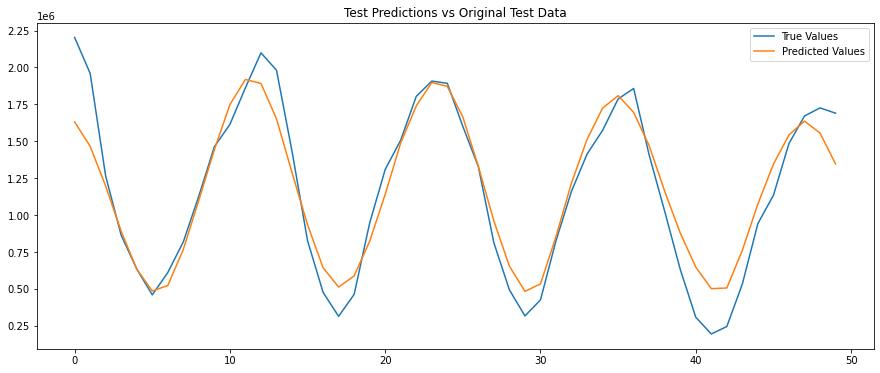

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 15ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

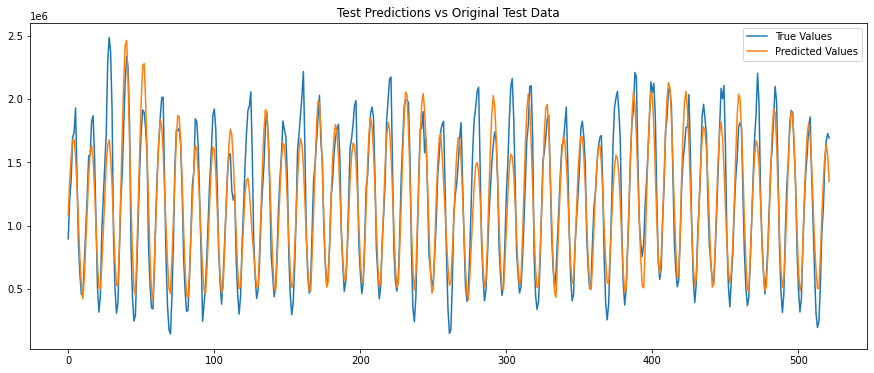

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()